### Import

In [1]:
import pandas as pd
import numpy as np

import re

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from difflib import get_close_matches

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import svm

from sklearn.metrics import f1_score

from xgboost import XGBClassifier, XGBRegressor, plot_importance

from sklearn.utils import shuffle

### Class and Functions

##### Trading

In [2]:
class DecisionMaking:
    """
    A class that takes pre-trained models and produce the next predicted values
    
    INPUT:
    columns_to_norm : a list of columns to be normalised by base
    base : the base column to normalise others
    list_to_add_unit_hour : list of rolling averages to add in the unit of hour, e.g.
                                list_to_add_unit_hour = [1, 2, 4] , will produce RAs of
                                1H, 2H, 4H (window calculated by dividing by the index_unit)

    index_unit : unit of index (whatever was used in the grouper), e.g. '15min' (takes minutes)
    model_avg : machine learning model for predicting the average
    model_high : machine learning model for predicting the high price
    model_low : machine learning model for predicting the low price

    """
    
    def __init__(self, columns_to_norm, base, list_to_add_unit_hour, index_unit, model_avg, model_high, model_low):
        
        self.columns_to_norm = columns_to_norm
        self.base = base
        self.list_to_add_unit_hour = list_to_add_unit_hour
        self.index_unit = index_unit
        
        self.model_avg  = model_avg
        self.model_high = model_high
        self.model_low  = model_low
        
        assert base not in columns_to_norm, "base should not be in the list of columns, as it will be dividing by 0"
    
    def get_raw_data(self, df):
        """
        raw 1 minute df
        """
        assert df.index.dtype == '<M8[ns]', "Index should be time"
        self.raw_1min_df = df.sort_index(ascending=True).copy(deep=True)
        
        return None
    
    def window_groupby(self, freq, agg_grouping, return_results=False):
        
        """
        return_results to see the table returned, otherwise, save at: self.df_windowed
        """
        
        df=self.raw_1min_df.copy(deep=True)
        grouper_key = self.raw_1min_df.index.name
        assert grouper_key != None, "no grouper key"
        
        df_temp = df.reset_index().groupby(pd.Grouper(key=grouper_key, freq=freq)).agg(agg_grouping)
        if 'open_time' in agg_grouping.keys():
            df_temp.columns = [open_time_refine(col) for col in df_temp.columns]

        df_temp['avg'] = df_temp['quote_asset_volume']/df_temp['volume']
        df_temp['avg'] = df_temp['avg'].fillna(method='ffill')  ## when volume is 0
        
        if return_results:
            return df_temp
            
        else:
            self.df_windowed = df_temp.copy(deep=True)
            return None


    
    def add_rolling_averges(self, return_results=False):
        """
        INPUT:
        return_results - boolean, defult False
        
        OUTPUT:
        (if return_results = True), dataframe with added rolling averages
        (else, save at self.df_wind_ra)
        """

        df_temp = self.df_windowed.copy(deep=True)

        rows = float(self.index_unit.replace('min',''))/60

        for ra in self.list_to_add_unit_hour:

            df_temp['ra_{x}H'.format(x=ra)] = df_temp['avg'].rolling(window=int(ra/rows)).mean()

        if return_results:
            print(".dropna(axis=0) not applied here")
            return df_temp
            
        else:
            self.df_wind_ra = df_temp.dropna(axis=0).copy(deep=True)
            return None


    
    def normalising_data(self, return_results=False):
        """
        INPUT:
        return_results - boolean, defult False

        OUTPUT:
        (if return_results = True), normalised dataframe
        (else, save at self.df_normalised_input)
        """
        
        df_temp = self.df_wind_ra.copy(deep=True)

        for col in self.columns_to_norm:
            df_temp[col] = 100 * ((df_temp[col].astype(np.float)/df_temp[self.base]) - 1)

        if return_results:
            return df_temp
            
        else:
            self.df_normalised_input = df_temp.copy(deep=True)
            return None
        
    def _return_predicted_vales(self, pred, base_value):
        final_value = (1.0 + pred/100) * base_value
        return final_value
    
    def get_predictions(self):
        """
        Return
        predicted: average, low, and high from the models
        """
        y_pred_avg_decision = self.model_avg.predict(self.df_normalised_input[self.columns_to_norm].values)
        y_pred_low_decision = self.model_low.predict(self.df_normalised_input[self.columns_to_norm].values)
        y_pred_high_decision = self.model_high.predict(self.df_normalised_input[self.columns_to_norm].values)

        y_pred_unscaled_avg = self._return_predicted_vales(y_pred_avg_decision[0], self.df_normalised_input[self.base].values[0])
        y_pred_unscaled_low = self._return_predicted_vales(y_pred_low_decision[0], self.df_normalised_input[self.base].values[0])
        y_pred_unscaled_high = self._return_predicted_vales(y_pred_high_decision[0], self.df_normalised_input[self.base].values[0])
            
        return {'pred_avg':y_pred_unscaled_avg,
                'pred_low':y_pred_unscaled_low,
                'pred_high':y_pred_unscaled_high}

In [3]:
class MrMarket:
    """
    A class that mimics real exchanges.
    
    INPUT:
    usd - usd values (i.e. starting capital)
    coin - coin values (i.e. number of crypto)
    last_event - last event name
    next_event - next event name
    taker_fee - cost of exceuting trades (which varies from exchange to exchange)
    """
    
    
    def __init__(self, usd, coin, last_event, next_event, taker_fee):
        
        self.usd_wallet = usd
        self.coin_wallet = coin
        self._LastEvent_ = last_event
        self._NextEvent_ = next_event
        self.buy_position = None
        self.sell_position = None
        self.current_low = None
        self.current_high = None
        
        self.taker_fee = taker_fee
        
        self.history_log = [{"time_of_event" : datetime.now(),  ## if back testing, now() shoud be the max time 
                              "event_name"   : self._LastEvent_,
                              "usd_wallet"   : self.usd_wallet, 
                              "coin_wallet"  : self.coin_wallet,
                              "next_action"  : self._NextEvent_,
                              "pred_low"     : self.buy_position,
                              "pred_high"    : self.sell_position,
                              "true_low"     : self.current_low,
                              "true_high"    : self.current_high
                            }]
        
        print("initialisation")
        display(pd.DataFrame(self.history_log))
        
        return None 
    
    
    
    def _event_log(self, event):
        """
        logs the event
        """
        
        self.history_log.append({"time_of_event" : self.time,  ## if back testing, now() shoud be the max time 
                                  "event_name"   :  event['event_name'],
                                  "usd_wallet"    : self.usd_wallet, 
                                  "coin_wallet"   : self.coin_wallet,
                                  "next_action"   : self._NextEvent_,
                                  "pred_low"     : self.buy_position,
                                  "pred_high"    : self.sell_position,
                                  "true_low"     : self.current_low,
                                  "true_high"    : self.current_high,
                                  "position_opened_at" : self.position_opened_at
                                        })

        return "Appened to history_log"
    
    def _CheckOrder_(self):
        """
        returns if an open order is there to be filled; also, what is the next event
        """
        return self._WaitingToFillOrder_, self._NextEvent_
    
    def data(self, row):
        """
        INPUT:
        row - a row of data which has the
              low, high, open and close price at a certain time (row.name)
        
        """
        self.current_low = row['low']
        self.current_high = row['high']
        self.current_open = row['open']
        self.current_close = row['close']
        self.time = row.name ## of that minute
        
    
    def open_buy_position(self, buy_price_set, sell_price_set, data_at_time):
        """
        Opens a buy position at said price, also stores a sell price which 
        will be used when the buy price order goes through
        
        INPUT:
        buy_price_set - buy price
        sell_price_set - sell price
        data_at_time - time of the event
        """
        self.buy_position = buy_price_set
        self.sell_position = sell_price_set
        
        self._LastEvent_ = "open_buy_position"
        self._NextEvent_ = "close_buy_position"
        
        self.position_opened_at = {'open_buy': data_at_time.name, 'open_sell': None}
            
        self.history_log.append({"time_of_event" : data_at_time.name,  ## if back testing, now() shoud be the max time 
                                  "event_name"    : self._LastEvent_,
                                  "usd_wallet"    : self.usd_wallet, 
                                  "coin_wallet"   : self.coin_wallet,
                                  "next_action"   : self._NextEvent_,
                                  "pred_low"     : buy_price_set,
                                  "pred_high"    : sell_price_set,
                                  "true_low"     : data_at_time['low'],
                                  "true_high"    : data_at_time['high'],
                                  "position_opened_at" : self.position_opened_at
                })
        

        self._WaitingToFillOrder_ = True
    
        return data_at_time.name
    
    def check_status(self, input_event):
        """
        check if an order should have gone through
        """
        
        assert self._NextEvent_ == input_event, "self event: {_NextEvent_} and input: {input_event} should be the same"
        
        if self._NextEvent_ == 'close_buy_position':
#             print("try to close buy position!!", self.time)
            if self.current_low < self.buy_position:
                
                "Buy executed, sell position opened"
                self.coin_wallet = self.coin_wallet + float(self.usd_wallet / self.buy_position) * (100 - self.taker_fee)/100
                self.usd_wallet = self.usd_wallet - self.usd_wallet
                self._NextEvent_ = "close_sell_position"
                
                self.position_opened_at = {'open_buy': None, 'open_sell': self.time}
                
                self._event_log({"event_name": "close_buy_position, (auto: opened sell position)"})
                
                return "Executed Buy"
            
            else:
                
                if (self.time - self.position_opened_at['open_buy']).total_seconds() >= 30*60:
                    assert pd.notnull(self.position_opened_at['open_buy']), "should have a timestampe"
                    
                    "Cancel trade, price expired"
                    
                    verdict = "Buy order expired, Reset"
                    

                    self.position_opened_at = None
                    self._WaitingToFillOrder_ = False
                    
                    self._NextEvent_ = "open_buy_position"
                    
                    self._event_log({"event_name": "expired buy order"})
                    
#                     print('heere>>>>>>>' ,verdict, self._NextEvent_, self.time)
                    
                    return verdict
                
                else:
                    verdict = "Buy condition not met"
                    self._event_log({"event_name": verdict})

                    return verdict
            
            
        elif self._NextEvent_ == 'close_sell_position':
            if self.current_high > self.sell_position:
                
                "Sell executed, waiting to open the next buy order"
                self.usd_wallet = self.usd_wallet + self.sell_position * self.coin_wallet * (100 - self.taker_fee)/100
                self.coin_wallet = self.coin_wallet - self.coin_wallet
                self._NextEvent_ = "open_buy_position"

                
                self._event_log({"event_name": "close_sell_position"})
                
                self._WaitingToFillOrder_ = False
                
                return "Executed Sell"
            
            else:
                
                if (self.time - self.position_opened_at['open_sell']).total_seconds() >= 30*60:
                    assert pd.notnull(self.position_opened_at['open_sell']), "should have a timestampe"
#                     print("sell order taking too long?",  self.time)
#                     !! ?? sell at a loss ??

#                 else:
                verdict = "Sell condition not met"
                self._event_log({"event_name": verdict})

                return verdict

In [4]:
def window_groupby(df, grouper_key, freq, agg_grouping):
    """
    Group every x minutes
    
    INPUT:
    df - dataframe
    grouper_key - column (name) to be grouped on (must be datetime)
    freq - frequency of grouping
    agg_grouping - dictionary of aggregations 
    
    OUTPUT:
    grouped dataframe
    """
    df_temp = df.reset_index().groupby(pd.Grouper(key=grouper_key, freq=freq)).agg(agg_grouping)
    
    if 'open_time' in agg_grouping.keys():
        df_temp.columns = [open_time_refine(col) for col in df_temp.columns]
    
    df_temp['avg'] = df_temp['quote_asset_volume']/df_temp['volume']
    
    return df_temp

In [5]:
def add_rolling_averges(df, list_to_add_unit_hour, index_unit):
    """
    INPUT:
    df - dataframe (assume the datafram is already sorted)
    list_to_add_unit_hour - list of rolling averages to add in the unit of hour, e.g.
                            list_to_add_unit_hour = [1, 2, 4] , will produce R.As of
                            1H, 2H, 4H (window calculated by dividing by the index_unit)
                            
    index_unit - unit of index (whatever was used in the grouper), e.g. '15min' (takes minutes)
    
    OUTPUT:
    dataframe with added rolling averages
    """
    df_temp = df
    
    rows = float(index_unit.replace('min',''))/60
    
    for ra in list_to_add_unit_hour:
        
        df_temp['ra_{x}H'.format(x=ra)] = df_temp['avg'].rolling(window=int(ra/rows)).mean()
    
    return df_temp

In [6]:
def run_decision(decision_class, df_past_hours):
    """
    Takes the last x hours of data and predict the values
    
    INPUT:
    decision_class - a class with ml model loaded
    df_past_hours - raw data for the past x hours to be considered
    
    
    OUTPUT:
    predicted: average, low, and high from the models
    
    """
    
    decision_class.get_raw_data(df_past_hours)
    decision_class.window_groupby(freq='15min', 
                      agg_grouping={'open': 'first',
                                     'high': 'max',
                                     'low': 'min',
                                     'close': 'last',
                                     'volume': 'sum',
                                     'quote_asset_volume': 'sum',
                                     'open_time': ['min', 'max', 'count']}
                     )
    decision_class.add_rolling_averges()
    decision_class.normalising_data()
    
#     display(decision_class.df_normalised_input[['open_time_max']])
    return (decision_class.get_predictions() )

In [7]:
def open_time_refine(txt):
    """refine text"""
    if txt[0] != 'open_time':
        return txt[0]
    
    else:
        return txt[0] + '_' +txt[1]

In [8]:
def normalising_data(df, columns, base):
    """
    INPUT:
    df - dataframe to normalise
    columns - list of columns to be normalised (column/base)
    base - name of the normalised base (denominator)
    
    
    OUTPUT:
    df - normalised dataframe
    """
    assert base not in columns, "base should not be in the list of columns, as it will be dividing by 0"
    
    df_temp = df.copy(deep=True)
    
    for col in columns:
        df_temp[col] = 100 * ((df_temp[col].astype(np.float)/df_temp[base]) - 1)
    
    return df_temp

#### Data Analysis

In [9]:
df_ETHUSD_1min = pd.read_parquet('../ETH-USDT.parquet')

In [10]:
df_ETHUSD_1min = df_ETHUSD_1min[df_ETHUSD_1min['volume'] != 0].sort_index(ascending=True)

In [11]:
agg_grouping = {'open':'first',
                'high':'max',
                'low':'min',
                'close':'last',
                'volume':'sum',
                'quote_asset_volume':'sum',
                'open_time':['min','max','count']
               }


In [12]:
df_15min = window_groupby(df=df_ETHUSD_1min,
                       grouper_key='open_time',
                       freq='15min',
                       agg_grouping=agg_grouping
                         )

In [13]:
df_prepare = add_rolling_averges(df_15min, [1,2,4], '15min').dropna(axis=0).copy(deep=True)

In [14]:
df_prepare['y_avg'] = df_prepare['avg'].shift(-1)

In [15]:
df_prepare['y_low'] = 100 * ((df_prepare['low'].shift(-1) - df_prepare['y_avg'])/df_prepare['y_avg'])
df_prepare['y_high'] = 100 * ((df_prepare['high'].shift(-1) - df_prepare['y_avg'])/df_prepare['y_avg'])
df_prepare['y_avg'] = 100 * ((df_prepare['avg'].shift(-1) - df_prepare['avg'])/df_prepare['avg'])

In [16]:
df_prepare = df_prepare[df_prepare['open_time_count'] == 15]

### ML Training

In [17]:
base = 'ra_1H'
columns_to_norm = [d for d in ['open','high','low','close','avg','ra_1H','ra_2H','ra_4H'] if d != base]
y_columns = ['y_avg','y_low','y_high']

In [18]:
df_normalised = normalising_data(df_prepare, columns=columns_to_norm, base=base)

In [19]:
## preparing dataframe for training
df_input = df_normalised[columns_to_norm + y_columns].copy(deep=True)

In [20]:
df_input = df_input[:-1]

In [21]:
df_input_set_aside = df_input[-17000:].copy(deep=True)

In [22]:
df_input_traintest = df_input[:-17000].copy(deep=True)

In [23]:
df_input_traintest = shuffle(df_input_traintest)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_input_traintest[columns_to_norm].values, 
                                                    df_input_traintest[['y_avg','y_low','y_high']].values ,
                                                    train_size=0.70,
                                                    random_state=42)

In [25]:
y_train_avg = np.copy(y_train[:,0])
y_train_low = np.copy(y_train[:,1])
y_train_high = np.copy(y_train[:,2])

y_test_avg = np.copy(y_test[:,0])
y_test_low = np.copy(y_test[:,1])
y_test_high = np.copy(y_test[:,2])

In [26]:
pipeline_xgb_avg_rel = Pipeline([
                            ('multi_clf', XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.75,
                                       colsample_bytree=1, max_depth=7) )
                            ])

In [27]:
pipeline_xgb_low = Pipeline([('multi_clf', XGBRegressor(n_estimators=100, 
                                                       learning_rate=0.1,
                                                       gamma=0,
                                                       subsample=0.75,
                                                       colsample_bytree=1,
                                                       max_depth=7) )
                            ])

pipeline_xgb_high = Pipeline([('multi_clf', XGBRegressor(n_estimators=100,
                                                         learning_rate=0.1,
                                                         gamma=0,
                                                         subsample=0.75,
                                                         colsample_bytree=1,
                                                         max_depth=7) )
                            ])

In [28]:
pipeline_xgb_low.fit(X_train, y_train_low)
pipeline_xgb_avg_rel.fit(X_train, y_train_avg)
pipeline_xgb_high.fit(X_train, y_train_high)

Pipeline(steps=[('multi_clf',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=7, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=8, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.75,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [29]:
pipeline_xgb_avg_rel._final_estimator.feature_importances_

array([0.0789095 , 0.1139935 , 0.1424469 , 0.33036315, 0.17767969,
       0.07623439, 0.0803729 ], dtype=float32)

In [30]:
pipeline_xgb_low._final_estimator.feature_importances_

array([0.03303806, 0.28210312, 0.42851874, 0.06021568, 0.04669992,
       0.06862583, 0.08079864], dtype=float32)

In [31]:
pipeline_xgb_high._final_estimator.feature_importances_

array([0.03217942, 0.23389718, 0.435915  , 0.07492605, 0.05992798,
       0.07854607, 0.08460832], dtype=float32)

In [32]:
data_4H = pd.DataFrame([], columns = ['open','high','low','close','volume','quote_asset_volume'])
data_4H.index.name = 'open_time'

In [33]:
decide = DecisionMaking(columns_to_norm = columns_to_norm,
                        base = base,
                        list_to_add_unit_hour = [1,2,4],
                        index_unit = '15min',
                        model_avg = pipeline_xgb_avg_rel,
                        model_high = pipeline_xgb_high,
                        model_low = pipeline_xgb_low)

In [34]:
min_df = df_ETHUSD_1min.iloc[0].name

In [35]:
max_df = df_ETHUSD_1min.iloc[-1].name

In [36]:
df_ETHUSD_1min_reindex = df_ETHUSD_1min.reindex(pd.date_range(start=min_df, end=max_df, freq='min')).copy(deep=True)

In [37]:
df_ETHUSD_1min_reindex = df_ETHUSD_1min_reindex.fillna(method='ffill')

In [38]:
df_ETHUSD_1min_reindex.index.name = 'open_time'

In [39]:
df_base = df_ETHUSD_1min_reindex[df_ETHUSD_1min_reindex.index >= '2020-12-01'][:239]  ## + 12 to make sure it starts on the multiples of quarter minutes
df_continue = df_ETHUSD_1min_reindex[df_ETHUSD_1min_reindex.index >= '2020-12-01'][239:]

In [40]:
### Action

In [53]:

history_log = [{'time': datetime.now(),
                'last_event': 'start outside log',
                'next_event': 'begin trading'}]
n = 0
to_skip_trade = False

## fee of 0.4%
downward_adjustment = 0  ## unit percent
dif_high_low = 3 ## unit percent
order_high_from_low = 2.5 ## unit percent, at least 0.4

# eth_bot1 = TradingBot(100, 0)
# next_event = eth_bot1.get_log()[-1]['next_action'] 

prediction_log = []

number_of_window = 0

_Waiting_ = False  ## waiting for orders
_LastEvent_ = 'initiation'
_NextEvent_ = 'open_buy_position'  # open_buy_position | close_buy_position | close_sell_position
                                   # open_sell_position <- should be done in MrMarket
                                    

MrMarket_ETH = MrMarket(usd=100,
                        coin=0, 
                        last_event=_LastEvent_,
                        next_event=_NextEvent_,
                        taker_fee=0.4)
wait_for_one = False
        
for k, row in df_continue.iterrows():
    """4H of data"""
    row_append =pd.Series( {'open' :row['open'],
                          'high' :row['high'],
                          'low'  :row['low'],
                          'close':row['close'],
                          'volume':row['volume'],
                          'quote_asset_volume':row['quote_asset_volume']
                       }, 
                     name = row.name
                     )

    df_base = df_base.append(row_append, ignore_index=False)
    
    ## if at 15min point, and ....
    if (n%15 == 0) and \
       (_NextEvent_ == 'open_buy_position') and \
       (_Waiting_ == False) :
#         print('ML training ---------------------', row.name)
        for_log = run_decision(decide, df_base) ## apend to log
        
#         print("condition:  ", 100 * (for_log['pred_high']/for_log['pred_low'] -1) > dif_high_low, 100 * (for_log['pred_high']/for_log['pred_low'] -1))
        
        ## check if the margin is okay
        if 100 * (for_log['pred_high']/for_log['pred_low'] -1) > dif_high_low:
            number_of_window += 1
            
            predicted_values = run_decision(decide, df_base)
            low_price_position = predicted_values['pred_low'] * ((100-downward_adjustment)/100)
            high_price_position = low_price_position * (100 + order_high_from_low)/100


            MrMarket_ETH.open_buy_position(low_price_position, high_price_position, row) # should then have a buy position opened at low price, then a sell position once that is triggered
            _LastEvent_ = _NextEvent_
            _Waiting_, _NextEvent_ = MrMarket_ETH._CheckOrder_() ## True, close_buy_position
        
            wait_for_one = True
            
            assert _Waiting_ in [True, False], "_Waiting_ must be boolean"
            assert _NextEvent_ in ['close_buy_position','close_sell_position']
            
            continue

        else:
            history_log.append({'time': row.name,
                                'last_event': "margin not met",
                                'next_event': _NextEvent_,
                                'detail'    : for_log})
      
    if wait_for_one:
        wait_for_one = False

    else:
        if _Waiting_ == True:
            ## All the below can be put in MrMarket

            MrMarket_ETH.data(row)  ## provide data for MrMarket
            if _NextEvent_ == 'close_buy_position': ## close sell position should be done with MrMarket
                _Verdict_ = MrMarket_ETH.check_status(_NextEvent_) ## check if true_low <= pred_low

                assert _Verdict_ in ['Buy condition not met', 'Executed Buy', 'Buy order expired, Reset']

                if _Verdict_ == 'Executed Buy':
                    _LastEvent_ = _NextEvent_
                    _Waiting_, _NextEvent_ = MrMarket_ETH._CheckOrder_()  ## should have already executed buy order, and open a sell order
                    assert _Waiting_ == True, "Should be still waiting for the execution"
                    assert _NextEvent_ == 'close_sell_position', "Next event should be close sell position"

                    history_log.append({'time': row.name,
                                        'last_event': _LastEvent_,
                                        'next_event': _Verdict_})

                elif _Verdict_ == 'Buy condition not met':
                    history_log.append({'time': row.name,
                                        'last_event': _LastEvent_,
                                        'next_event': _Verdict_})

                elif _Verdict_ == 'Buy order expired, Reset':
                    history_log.append({'time': row.name,
                                        'last_event': _LastEvent_,
                                        'next_event': _Verdict_})
                    _Waiting_ = False
                    _NextEvent_ = 'open_buy_position'

                else:
                    print("!! _Verdict_ is wrong!! Shouldn't show: {} ".format(_Verdict_))
                    break 
                    #! shouldn't have anything here

            else:
                _Verdict_ = MrMarket_ETH.check_status(_NextEvent_)
                assert _Verdict_ in ['Sell condition not met', 'Executed Sell']

                if _Verdict_ == 'Executed Sell':
                    _LastEvent_ = _NextEvent_
                    _Waiting_, _NextEvent_ = MrMarket_ETH._CheckOrder_()  ## should have already executed sell order, and should be just waiting now
                    assert _Waiting_ == False, "Should not be waiting for anything, ready to accept a new buy order"
                    assert _NextEvent_ == 'open_buy_position', "Next event should be open buy position"

                    history_log.append({'time': row.name,
                                        'last_event': _LastEvent_,
                                        'next_event': _Verdict_})

                else: ## sell condition not met
                    history_log.append({'time': row.name,
                                        'last_event': _LastEvent_,
                                        'next_event': _Verdict_})


    #             elif: ## expired order


        else:
            history_log.append({'time': row.name,
                                'last_event': "some condition not met",
                                'next_event': _NextEvent_,
                                'detail'    : for_log})
    
    n += 1 
    df_base = df_base[1:]

initialisation


,time_of_event,event_name,usd_wallet,coin_wallet,next_action,pred_low,pred_high,true_low,true_high
0,2021-02-13 14:21:49.845950,initiation,100,0,open_buy_position,None,None,None,None


In [54]:
trading_log = pd.DataFrame(MrMarket_ETH.history_log)

In [55]:
trading_log

,time_of_event,event_name,usd_wallet,coin_wallet,next_action,pred_low,pred_high,true_low,true_high,position_opened_at
0,2021-02-13 14:21:49.845950,initiation,100.000000,0.000000,open_buy_position,NaN,NaN,NaN,NaN,NaN
1,2020-12-01 03:59:00.000000,open_buy_position,100.000000,0.000000,close_buy_position,608.382577,623.592142,603.640015,605.500000,"{'open_buy': 2020-12-01 03:59:00, 'open_sell':..."
2,2020-12-01 04:01:00.000000,"close_buy_position, (auto: opened sell position)",0.000000,0.163713,close_sell_position,608.382577,623.592142,604.030029,605.109985,"{'open_buy': None, 'open_sell': 2020-12-01 04:..."
3,2020-12-01 04:02:00.000000,Sell condition not met,0.000000,0.163713,close_sell_position,608.382577,623.592142,604.659973,606.330017,"{'open_buy': None, 'open_sell': 2020-12-01 04:..."
4,2020-12-01 04:03:00.000000,Sell condition not met,0.000000,0.163713,close_sell_position,608.382577,623.592142,606.000000,606.799988,"{'open_buy': None, 'open_sell': 2020-12-01 04:..."
...,...,...,...,...,...,...,...,...,...,...
36487,2020-12-27 16:59:00.000000,Buy condition not met,105.130233,0.000000,close_buy_position,682.517925,699.580873,694.539978,696.679993,"{'open_buy': 2020-12-27 16:33:00, 'open_sell':..."
36488,2020-12-27 17:00:00.000000,Buy condition not met,105.130233,0.000000,close_buy_position,682.517925,699.580873,693.989990,696.619995,"{'open_buy': 2020-12-27 16:33:00, 'open_sell':..."
36489,2020-12-27 17:01:00.000000,Buy condition not met,105.130233,0.000000,close_buy_position,682.517925,699.580873,693.289978,695.950012,"{'open_buy': 2020-12-27 16:33:00, 'open_sell':..."
36490,2020-12-27 17:02:00.000000,Buy condition not met,105.130233,0.000000,close_buy_position,682.517925,699.580873,692.200012,694.919983,"{'open_buy': 2020-12-27 16:33:00, 'open_sell':..."


<AxesSubplot:>

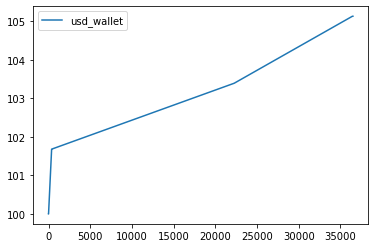

In [56]:
trading_log[trading_log['usd_wallet'] != 0][['usd_wallet']].plot()

In [60]:
trading_log

,time_of_event,event_name,usd_wallet,coin_wallet,next_action,pred_low,pred_high,true_low,true_high,position_opened_at
0,2021-02-13 14:21:49.845950,initiation,100.000000,0.000000,open_buy_position,NaN,NaN,NaN,NaN,NaN
1,2020-12-01 03:59:00.000000,open_buy_position,100.000000,0.000000,close_buy_position,608.382577,623.592142,603.640015,605.500000,"{'open_buy': 2020-12-01 03:59:00, 'open_sell':..."
2,2020-12-01 04:01:00.000000,"close_buy_position, (auto: opened sell position)",0.000000,0.163713,close_sell_position,608.382577,623.592142,604.030029,605.109985,"{'open_buy': None, 'open_sell': 2020-12-01 04:..."
3,2020-12-01 04:02:00.000000,Sell condition not met,0.000000,0.163713,close_sell_position,608.382577,623.592142,604.659973,606.330017,"{'open_buy': None, 'open_sell': 2020-12-01 04:..."
4,2020-12-01 04:03:00.000000,Sell condition not met,0.000000,0.163713,close_sell_position,608.382577,623.592142,606.000000,606.799988,"{'open_buy': None, 'open_sell': 2020-12-01 04:..."
...,...,...,...,...,...,...,...,...,...,...
36487,2020-12-27 16:59:00.000000,Buy condition not met,105.130233,0.000000,close_buy_position,682.517925,699.580873,694.539978,696.679993,"{'open_buy': 2020-12-27 16:33:00, 'open_sell':..."
36488,2020-12-27 17:00:00.000000,Buy condition not met,105.130233,0.000000,close_buy_position,682.517925,699.580873,693.989990,696.619995,"{'open_buy': 2020-12-27 16:33:00, 'open_sell':..."
36489,2020-12-27 17:01:00.000000,Buy condition not met,105.130233,0.000000,close_buy_position,682.517925,699.580873,693.289978,695.950012,"{'open_buy': 2020-12-27 16:33:00, 'open_sell':..."
36490,2020-12-27 17:02:00.000000,Buy condition not met,105.130233,0.000000,close_buy_position,682.517925,699.580873,692.200012,694.919983,"{'open_buy': 2020-12-27 16:33:00, 'open_sell':..."


In [67]:
df_result_to_plot = df_continue[['open','close']].reset_index().merge(trading_log[['time_of_event','event_name','usd_wallet']],
                                                       left_on='open_time',
                                                       right_on='time_of_event',
                                                       how='left').set_index('open_time')

In [92]:
df_result_to_plot['event_name'].unique()

array(['open_buy_position', nan,
       'close_buy_position, (auto: opened sell position)',
       'Sell condition not met', 'close_sell_position',
       'Buy condition not met', 'expired buy order'], dtype=object)

In [90]:
df_result_to_plot[df_result_to_plot['event_name'] == 'open_buy_position']

,open,close,time_of_event,event_name,usd_wallet
open_time,,,,,
2020-12-01 03:59:00,605.219971,605.140015,2020-12-01 03:59:00,open_buy_position,100.000000
2020-12-01 11:45:00,617.179993,620.570007,2020-12-01 11:45:00,open_buy_position,101.681640
2020-12-17 18:16:00,640.880005,634.429993,2020-12-17 18:16:00,open_buy_position,103.391559
2020-12-27 15:02:00,694.159973,694.869995,2020-12-27 15:02:00,open_buy_position,105.130233
2020-12-27 16:33:00,696.210022,696.780029,2020-12-27 16:33:00,open_buy_position,105.130233


In [99]:
df_result_to_plot[df_result_to_plot['event_name'] == 'close_buy_position']

,open,close,time_of_event,event_name,usd_wallet
open_time,,,,,


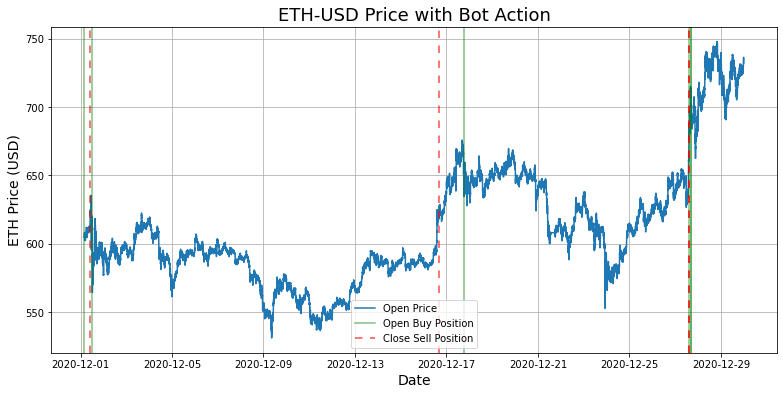

In [136]:
fig, ax = plt.subplots(figsize =(13,6))

# df_result_to_plot[['open','usd_wallet']].plot()

ax.plot(df_result_to_plot.index, df_result_to_plot['open'], label='Open Price')

for k, v in df_result_to_plot[df_result_to_plot['event_name'] == 'open_buy_position'].iterrows():
    plt.axvline(k, c='g',alpha =0.5)
    
# for k, v in df_result_to_plot[df_result_to_plot['event_name'] == 'close_buy_position, (auto: opened sell position)'].iterrows():
#     plt.axvline(k, dashes=(5,5), c='r', alpha = 0.7)
plt.axvline(k, c='g',alpha =0.5, label='Open Buy Position')

for k, v in df_result_to_plot[df_result_to_plot['event_name'] == 'close_sell_position'].iterrows():
    plt.axvline(k, dashes=(5,5), c='r', alpha = 0.7)
plt.axvline(k, dashes=(5,5), c='r', alpha = 0.7, label='Close Sell Position')

ax.legend()

ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('ETH Price (USD)', fontsize=14)
ax.set_title("ETH-USD Price with Bot Action", fontsize=18)

plt.grid()
plt.show()